In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import glob
import zipfile
import rasterio
import os
import xarray as xr
import json
from rasterstats import zonal_stats
from rasterio.transform import from_origin

print(os.getcwd())
from pathlib import Path
folder = Path(r'../Data') # assumes working directory is onhm-fetcher-parser
print(folder)
shapefiles = folder.glob("*_0[1].shp")
# shapefiles = folder.glob("*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)
# gdf.plot()
print(gdf)

Populating the interactive namespace from numpy and matplotlib
B:\GitRepos\onhm-fetcher-parser\notebooks
..\Data
       POI_ID  hru_id_nat  hru_id_reg region  \
0     7733855           1           1     01   
1     7733919           2           2     01   
2     7732571           3           3     01   
3     7732387           4           4     01   
4     7733327           5           5     01   
...       ...         ...         ...    ...   
2457   719280        2458        2458     01   
2458   805345        2459        2459     01   
2459   806793        2460        2460     01   
2460   807073        2461        2461     01   
2461   725382        2462        2462     01   

                                               geometry  
0     POLYGON ((-73.37147648799998 41.11232830300003...  
1     POLYGON ((-73.38531621599998 41.13467480400004...  
2     POLYGON ((-73.41946539799994 41.16068341300007...  
3     POLYGON ((-73.41096625099993 41.15832593000005...  
4     (POLYGON ((-73

In [2]:
import requests
from requests.exceptions import HTTPError
from datetime import datetime, timedelta
from urllib.parse import urlencode

prcpurl = 'https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1328/2018/daymet_v3_tmax_2018_na.nc4'
prcppayload = {
    'var': 'lat&var=lon&var=tmax',
    'north': '54',
    'west': '-126',
    'east': '-65',
    'south': '23',
    'disableProjSubset': 'on',
    'horizStride': '1',
    'time_start': '2018-12-31T00:00:00Z',
    'time_end': '2018-12-31T00:00:00Z',
    'timeStride': '1',
    'accept': 'netcdf'}    
try:
    s = requests.Session()
    #https://github.com/psf/requests/issues/1454
    qry = urlencode(prcppayload).replace('%26','&')
    qry = qry.replace('%3D', '=')
    print(qry)
    tmaxfile = requests.get(prcpurl, params=qry)
    tmaxfile.raise_for_status()
except HTTPError as http_err:
    print(f'HTTP error occured: {http_err}')
except Exception as err:
    print(f'Other error occured: {err}')
else:
    print('Gridmet data retrieved!')
    
with open('tmax_test2.nc', 'wb') as fh:
    fh.write(tmaxfile.content)
fh.close

var=lat&var=lon&var=tmax&north=54&west=-126&east=-65&south=23&disableProjSubset=on&horizStride=1&time_start=2018-12-31T00%3A00%3A00Z&time_end=2018-12-31T00%3A00%3A00Z&timeStride=1&accept=netcdf
Gridmet data retrieved!


<function BufferedWriter.close>

In [3]:

dirPath = 'tmax_test2.nc'

#--------------------------------------------------------
#   FORM FILENAME AND GET HANDLE TO FILE AND DATA
#--------------------------------------------------------
fullfilename= dirPath
print(fullfilename)

ds = xr.open_dataset(fullfilename)

print(ds)

# df = ds.to_dataframe()

print('\n The meta data is: \n', ds.attrs)
lathandle=ds['lat']
lonhandle=ds['lon']
timehandle=ds['time']
datahandle=ds['tmax']
dhlat = ds['lat']
dhlon = ds['lon']
crshandle=ds['lambert_conformal_conic']
print('\n The crs meta data is \n', crshandle.attrs)
print(datahandle)
# crstransform = crshandle.attrs['GeoTransform']
# print(crstransform)

#collect data to describe geotransform
lonmin = float(ds.attrs['geospatial_lon_min'])
latmax = float(ds.attrs['geospatial_lat_max'])
# lonres = float(ds.attrs['geospatial_lon_resolution'])
# latres = float(ds.attrs['geospatial_lon_resolution'])

#Print some information on the data

print('\n Data attributes, sizes, and coords \n') 
print('\n Data attributes are: \n',datahandle.attrs)
print('\n Data sizes are: \n', datahandle.sizes)
print('\n Data coords are: \n', datahandle.coords)
print('\n Lat coords are: \n', dhlat.attrs)

ts = datahandle.sizes
print(type(ts))
print(ts['time'])
dayshape = ts['time']
Lonshape = ts['x']
Latshape = ts['y']
#dayshape,lonshape,latshape = datahandle.values.shape
print(dayshape, Lonshape, Latshape)

# datahandle.values[dayshape-1,:,:].shape

# print(lathandle.values.shape)
# print(type(lathandle.values))
# print(datahandle.dtype)
# print(np.isfortran(datahandle.values))

tmax_test2.nc
<xarray.Dataset>
Dimensions:                  (time: 1, x: 5904, y: 3377)
Coordinates:
  * y                        (y) float32 1687.0 1686.0 ... -1688.0 -1689.0
  * x                        (x) float32 -2650.25 -2649.25 ... 3251.75 3252.75
  * time                     (time) datetime64[ns] 2018-12-30T12:00:00
Data variables:
    lat                      (y, x) float32 ...
    lambert_conformal_conic  int16 ...
    lon                      (y, x) float32 ...
    tmax                     (time, y, x) float32 ...
Attributes:
    _NCProperties:       version=1|netcdflibversion=4.6.1|hdf5libversion=1.10.2
    start_year:          2018
    source:              Daymet Software Version 3.0
    Version_software:    Daymet Software Version 3.0
    Version_data:        Daymet Data Version 3.0
    Conventions:         CF-1.6
    citation:            Please see http://daymet.ornl.gov/ for current Dayme...
    references:          Please see http://daymet.ornl.gov/ for current infor..

In [8]:
# add tmax column to dataframe
gdf['tmax']=0.0

#open weight data
# wght_df = pd.read_csv('../Data/hru_metdata_weights.csv')
# wght_df_40 = pd.read_csv('../Data/hru_metdata_weights_40m.csv')
# wght_df_500 = pd.read_csv('../Data/hru_metdata_weights_500m.csv')
# wght_UofI = pd.read_csv('../Data/hru_uofimetdata_weights.csv')
wght_dm = pd.read_csv('../pkg/tmp_weights.csv')
# print(len(wght_df['hru_id_nat'].unique()), len(wght_df_40['hru_id_nat'].unique()), 
#       len(wght_df_500['hru_id_nat'].unique()), len(wght_UofI['hru_id_nat'].unique()))
print(wght_dm.head())

#iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
ndata = datahandle.values[dayshape-1,:,:].flatten(order='K')
# ndata=np.nan_to_num(data)
print(ndata[1000:])
# def w_mean(data)
3 = wght_dm.groupby('hru_id_nat')
print(len(gdf), len(unique_hru_ids))

def get_wval(grp, ndata):
    ttmax = twght = 0.0
    for index, row in grp.iterrows():
        ttmax += row['w']*ndata[np.int(row['grid_ids'])]
        twght += row['w']
    return ttmax/twght
def np_get_wval(grp, ndata):
    return np.average(ndata[grp['grid_ids'].values.astype(int)], weights=grp['w'])
def np_get_wval2(grp, ndata):
    mdata = np.ma.masked_array(ndata[grp['grid_ids'].values.astype(int)], np.isnan(ndata[grp['grid_ids'].values.astype(int)]))
    return np.ma.average(mdata, weights=grp['w'])
#     return np.average(ndata[grp['grid_ids'].values.astype(int)], weights=grp['w'])
    
# unique_hru_ids.get_group(gdf['hru_id_nat']).agg({'tmax': np_get_wval(weight_id_rows, ndata)})    
td = np.zeros(len(gdf.index))
for index, row in gdf.iterrows():
    weight_id_rows = unique_hru_ids.get_group(row['hru_id_nat'])
#     print(weight_id_rows['grid_ids'].values.astype(int))
#     unique_hru_ids.get_group(row['hru_id_nat']).agg({'tmax': np_get_wval(weight_id_rows, ndata)})
#     gdf.loc[gdf.index[index],'tmax'] = np_get_wval(weight_id_rows, ndata)-273.5
    tmp = np_get_wval2(weight_id_rows, ndata)
    if index == 1:
        print(type(tmp))
    td[index] = np_get_wval2(weight_id_rows, ndata)
#     if td[index] < 0.0:
#         print(ndata[weight_id_rows['grid_ids'].values.astype(int)], weight_id_rows['w'])
#     print(index, td[index])
#     if row['hru_id_nat'] == 829:
#         print("in test")
#         for i2, el in weight_id_rows.iterrows():
#             print(el['w'], ndata[el['grid_ids'].astype(int)])
#         print(np.average(ndata[weight_id_rows['grid_ids'].values.astype(int)], weights=weight_id_rows['w'])-273.5)
#     print(index, row['hru_id_nat'], np_get_wval(weight_id_rows, ndata)-273.5)
#     gdf.loc[gdf.index[index], 'tmax'] =
# #     print(get_wval(weight_id_rows, ndata)-273.5)
# #     row.loc['tmax']=get_wval(weight_id_rows, ndata)-273.5
# #     gdf.loc[gdf.index[index], 'tmax'] = get_wval(weight_id_rows, ndata)-273.5
# print(len(td))
# gdf['tmax'] = gpd.GeoSeries([np.transpose(td)], index=gdf.index)
gdf['tmax'] = td.tolist()
gdf['tmax'].fillna(0.0)
# print(td.tolist())
print('min/max', gdf['tmax'].min(), gdf['tmax'].max())
# print(gdf)
# gdf.plot(figsize=(12,12), column = 'tmax',linewidth=0.25, edgecolor='white')    
# print(gdf.groupby(tmax).min)
# f, ax = plt.subplots(2, figsize=(12,12))
# gdf.plot(ax=ax[0], column = 'tmax',linewidth=0., edgecolor='white', scheme='quantiles')
# ptmax = ds.air_temperature-273.5
# ptmax_1 = ptmax.isel(day=dayshape-1)
# lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)
# ptmax_1.plot(ax=ax[1], levels=lvs, cmap='viridis')

   grid_ids  hru_id_nat         w
0   8816431           1  0.026643
1   8816432           1  0.074396
2   8834138           1  0.071368
3   8834137           1  0.020091
4   8840039           1  0.021752
[-10.  -10.   -9.5 ...   nan   nan   nan]
2462 2462
<class 'numpy.float64'>
min/max -13.76232863064752 7.855260651355844


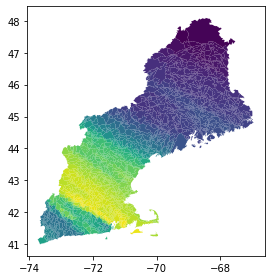

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
f, ax = plt.subplots(1)
ax.set_aspect('equal')
# ax.axis('equal')
# ax1.set(xlim=(-130, -60), ylim=(20, 55))
# divider_0 = make_axes_locatable(ax[0])
# cax_0 = divider_0.append_axes("right", size="5%", pad=0.1)
lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.1)
gdf.plot(ax=ax, column = 'tmax',linewidth=0., edgecolor='white', k=20)
f.savefig('hru.png')
f.tight_layout()
# f1, ax1 = plt.subplots(1)
# ax1.set_aspect('equal')
# # ax1.set(xlim=(-130, -60), ylim=(20, 55))
# ptmax = ds.air_temperature-273.5
# ptmax_1 = ptmax.isel(day=dayshape-1)
# ptmax_1.plot(ax=ax1, levels=lvs, cmap='viridis')
# f1.tight_layout()
# f1.savefig('gridmet.png')

In [10]:
gdf.head()


,POI_ID,hru_id_nat,hru_id_reg,region,geometry,tmax
0,7733855,1,1,01,POLYGON ((-73.37147648799998 41.11232830300003...,-2.571265
1,7733919,2,2,01,POLYGON ((-73.38531621599998 41.13467480400004...,-2.848760
2,7732571,3,3,01,POLYGON ((-73.41946539799994 41.16068341300007...,-3.000000
3,7732387,4,4,01,POLYGON ((-73.41096625099993 41.15832593000005...,-3.000000
4,7733327,5,5,01,(POLYGON ((-73.28636293699998 41.1278083500000...,-4.500000
